# GENERATION + AUGMENTATION TEST

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
#we are using a dataset from kaggle. Don't forget to load a kaggle.json file before running this cell
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch==1.13.1
! pip install sdv
! pip install faker
! pip install realtabformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 79% 52.0M/66.0M [00:00<00:00, 127MB/s]
100% 66.0M/66.0M [00:00<00:00, 125MB/s]


In [ ]:
!kaggle datasets download -d kartik2112/fraud-detection

!unzip fraud-detection.zip

 92% 186M/202M [00:01<00:00, 143MB/s]
100% 202M/202M [00:01<00:00, 166MB/s]
Archive:  fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from collections import OrderedDict
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
import torch
import re
from sdv.metadata import SingleTableMetadata
from realtabformer import REaLTabFormer
 


class Generator:

    def __init__(self, data, architecture, n_samples, num_epochs=None, num_bootstrap = None ,categorical_columns=None, sensitive_columns=None):

        """
        :param n_epochs: the number of epochs used for training, default is 200
        :param num_bootstraps: number of bootstraps for the RealTabFormer, default is 500
        :param n_samples: the number of rows to generate
        :param architecture: the chosen architecture, one of ['CTGAN', 'GaussianCopula', 'RealTabFormer']
        :param data: the data that should be trained on, should be in a pandas dataframe
        :param categorical_columns: a list with categorical columns
        :param sensitive_columns: a dict with sensitive columns and what  category they belong to
        The categories can be found in the faker_categorical function

        The metadata: an sdv metadata object required to call CTGAN and other methods
        Also required for similarity checks
        """
        if num_epochs is not None:
          self.num_epochs = num_epochs
        else: 
          # Default value for RealTabFormer and could be enough for CTGAN
          self.num_epochs = 200
        if num_bootstrap is not None:
          self.num_bootstrap = num_bootstrap
        else: 
          # Set to default for RealTabFormer
          self.num_bootstrap = 500 
        self.n_samples = n_samples
        if architecture in ['CTGAN', 'GaussianCopula', 'RealTabFormer']:
            self.architecture = architecture
        else:
            print('The requested architecture is not available')
            raise ValueError
        print('Retrieving metadata, check with generator.metadata')
        self.data = data
        self.metadata = self.create_metadata()
        self.categorical_columns = categorical_columns
        self.sensitive_columns = sensitive_columns



    def create_metadata(self):
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=self.data)
        return metadata

    def generate(self):
        """
        Based on the chosen architecture, this function returns synthetically generated data
        :return: synthetic data, a pandas dataframe
        """

        #  TODO: Add more generators, especially PATEGAN or other differentially private ones synthcity seems to have
        #  implementations of these, but I have not been able to import their library

        if self.architecture == "CTGAN":
            model = CTGANSynthesizer(metadata=self.metadata, epochs=self.num_epochs, verbose=True)
            model.fit(self.data)
            synth_data = model.sample(self.n_samples)

        elif self.architecture == "GaussianCopula":
            model = GaussianCopulaSynthesizer(metadata=self.metadata)
            model.fit(self.data)
            synth_data = model.sample(self.n_samples)
        elif self.architecture == "RealTabFormer":
            model = REaLTabFormer(
                      model_type="tabular",
                      epochs = self.num_epochs,
                      gradient_accumulation_steps=4,
                      # Output log each 100 steps
                      logging_steps=100)
            model.fit(self.data, num_bootstrap = self.num_bootstrap)
            synth_data = model.sample(n_samples = self.n_samples)


        return synth_data

    def faker_categorical(self, seed=None):
        """
        Instantiates Faker, generates fake data for it
        WARNING: data generated here should not be used for ML models
        :param seed: int, random seed, defaults
        """

        # TODO: Find a way to make this generalizable, f.e. create many attributes, and return the ones asked

        seed = seed or random.seed()
        # We can initialize the faker with multiple locations: can now draw addresses and names from
        # Germany, US, UK, Spain, France, Italy. Either just a list => all equal weights, or an ordered
        # dictionary in which weights can be specified.
        locale_list = ['de_DE', 'en_US', 'en_GB', 'es_ES', 'fr_FR', 'it_IT']
        fake = Faker(locale_list)
        fake.seed_instance(seed)
        # check whether the ID generated is already in use
        used_ids = set()
        output = []
        for i in range(self.n_samples):
            # select a locale at random => will allow us to generate internally consistent city-country pairs
            # or name/email pairs. Problem is that not all countries might be able to generate all of these
            # attributes. For example Belgium can't create IP-addresses
            locale = np.random.choice(locale_list)
            while True:
                new_id = fake.random_int(min=1, max=self.n_samples)
                if new_id not in used_ids:
                    used_ids.add(new_id)
                    break

            gender = np.random.choice(["Male", "Female"], p=[0.5, 0.5])
            # this works, but it's technical debt, talk to Léo about it
            if gender == "male":
                first_name = fake[locale].first_name_male()
            else:
                first_name = fake[locale].first_name_female()
            last_name = fake[locale].last_name()
            row = {
                "id": new_id,
                "first_name": first_name,
                "last_name": last_name,
                # take everything before @, and replace with first name.lastname
                "email": re.sub(r'^(.*?)@', first_name + "." + last_name + "@", fake[locale].free_email()),
                "gender": gender,
                "ip_address": fake[locale].ipv4_private(),
                "nationality": fake[locale].current_country(),
                "city": fake[locale].city()
            }
            output.append(row)

        df = pd.DataFrame(output, columns=self.sensitive_columns)
        return df

## Similarity check

In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sdv.evaluation.single_table import evaluate_quality

# TODO: ML model performance 


class SimilarityCheck:

    '''
    Check the quality of the synthetic data both visually and with metrics
    '''

    def __init__(self, real_data, synthetic_data, cat_cols, metadata):
        self.real_data = real_data
        self.synthetic_data = synthetic_data
        if cat_cols is not None:
          self.cat_cols = cat_cols
        else:
          self.cat_cols = []
        self.metadata = metadata


    def comparison_columns(self):
        '''
        :return: the KL divergence for numerical variables...
        tested and works
        '''
        quality_report = evaluate_quality(
          real_data=self.real_data,
          synthetic_data=self.synthetic_data,
          metadata=self.metadata)
        print(quality_report)
        print(quality_report.get_details(property_name='Column Shapes'))


    def visual_comparison_columns(self):
        '''
        Plot data in one of three ways:
        1) numeric columns are plotted using the densities
        2) categorical columns with limited categories are plotted with bar plots
        3) categorical columns with many categories do not show the values, if performance looks problematic
        we encourage further exploration of these columns
        '''
        if (self.real_data.columns != self.synthetic_data.columns).all():
            print('Columns in real and synthetic data not the same!')
            return

        fig, ax = plt.subplots(nrows=len(self.real_data.columns), figsize=(10, len(self.real_data.columns)*4))
        fig.tight_layout(pad = 5)
        for i, column in enumerate(self.real_data.columns):
            if column not in self.cat_cols:
                sns.kdeplot(self.real_data[column], ax=ax[i], label='Real', fill=True, color='c')
                sns.kdeplot(self.synthetic_data[column], ax=ax[i], label='Synthetic', fill=True, color='m')
            elif len(self.real_data[column].unique()) <= 5:
                sns.histplot(data = self.real_data,x = column, ax=ax[i],bins = len(self.real_data[column].unique()), label='Real', stat = 'density', color='c',discrete = False,element = 'step')
                sns.histplot(data = self.synthetic_data,x = column, ax=ax[i], bins = len(self.real_data[column].unique()),label='Synthetic', stat = "density", color='m',discrete = False ,element = 'step')
            else:
                sns.histplot(data = self.real_data,x = column, ax=ax[i], label='Real', fill = False,stat = 'density', color='c',discrete = False,element = 'step')
                sns.histplot(data = self.synthetic_data,x = column, ax=ax[i], label='Synthetic', fill = False,stat = "density", color='m',discrete = False ,element = 'step')
                ax[i].set_xticklabels([])
            ax[i].set_title(f'Comparison of {column}')
            ax[i].autoscale_view()
            ax[i].set_xlabel(column)
            ax[i].legend()
        plt.show()

    def compare_correlations(self):
        '''
        Compare correlation matrices
        :return:
        '''
        fig, ax = plt.subplots(figsize=(len(self.real_data.columns), (len(self.real_data.columns))))
        diff_corr = abs(self.real_data.corr() - self.synthetic_data.corr())
        mask = np.tril(np.ones_like(diff_corr, dtype=bool))
        sns.heatmap(diff_corr, mask=mask)
        ax.set_title('Differences in correlation values real and synthetic data')

    def compare_model_performance(self, fitted_model_real, fitted_model_synth, X_test, y_test):
        """
        Method that computes how close the scores of a model trained on the real vs. synthetic
        data are.
        """
        score_real = fitted_model_real.score(X_test, y_test)
        score_synth = fitted_model_synth.score(X_test, y_test)
        print(f"Score on real dataset: {score_real}\nScore on synthetic dataset: {score_synth}")
        return score_real, score_synth

In [ ]:
df = pd.read_csv('fraudTrain.csv')
df = df.sample(frac=0.08,random_state=1,ignore_index=True)

In [ ]:
print(len(df))

103734


In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,94102,2019-02-25 08:24:40,374497717543058,fraud_Funk Group,grocery_net,20.00,Linda,Hurst,F,31701 Tucker Square Suite 893,Wilton,ND,58579,47.1709,-100.7944,1190,"Designer, ceramics/pottery",1948-06-30,1595dec12f6f19ceaae9b7df0f8af5c0,1330158280,46.398331,-99.813959,0
1,198791,2019-04-12 19:50:15,4428154703770710,"fraud_Prosacco, Kreiger and Kovacek",home,284.88,Brittany,Guerra,F,79209 Gary Dale,Colton,WA,99113,46.5901,-117.1692,761,Chief Marketing Officer,1943-06-30,0ed26b649ed0fce94d8e632b7208dea0,1334260215,45.687331,-117.488135,0
2,1238587,2020-05-31 21:50:53,213148039875802,"fraud_Langworth, Boehm and Gulgowski",shopping_net,5.07,Jill,Jacobs,F,034 Kimberly Mountains,Brandon,FL,33510,27.9551,-82.2966,79613,Environmental consultant,1978-11-30,7096316ec1a4b261e8613013827abae7,1370037053,27.254081,-81.974799,0
3,619078,2019-09-20 17:06:52,2283743876903625,fraud_Conroy-Emard,food_dining,45.38,Shannon,Williams,F,9345 Spencer Junctions Suite 183,Alpharetta,GA,30009,34.0770,-84.3033,165556,Prison officer,1997-12-27,d02c35d7bda19c3da84b6d01f02da7e8,1348160812,34.551957,-83.374265,0
4,573850,2019-08-31 23:22:50,4798937978667559470,fraud_Adams-Barrows,health_fitness,27.52,Robert,Williams,M,09419 Lewis Rapids,Bay City,MI,48706,43.6088,-83.9530,67858,Water quality scientist,1995-03-13,dccf059d9fdc15f1fb9d2abb50e7314b,1346455370,43.032957,-83.521294,0


In [ ]:
#Dropping variables to:
#  - Remove sensible data
#  - Remove variables with not predictive value
#  - Remove variables that would increase the computational complexity of the generator
 
df = df.drop(['first','last','Unnamed: 0','zip','trans_num','cc_num','city','merchant','job','street'],axis = 1)

In [ ]:
df.dtypes

trans_date_trans_time     object
category                  object
amt                      float64
gender                    object
state                     object
lat                      float64
long                     float64
city_pop                   int64
dob                       object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [ ]:
df.head()

,trans_date_trans_time,category,amt,gender,state,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud
0,2019-02-25 08:24:40,grocery_net,20.00,F,ND,47.1709,-100.7944,1190,1948-06-30,1330158280,46.398331,-99.813959,0
1,2019-04-12 19:50:15,home,284.88,F,WA,46.5901,-117.1692,761,1943-06-30,1334260215,45.687331,-117.488135,0
2,2020-05-31 21:50:53,shopping_net,5.07,F,FL,27.9551,-82.2966,79613,1978-11-30,1370037053,27.254081,-81.974799,0
3,2019-09-20 17:06:52,food_dining,45.38,F,GA,34.0770,-84.3033,165556,1997-12-27,1348160812,34.551957,-83.374265,0
4,2019-08-31 23:22:50,health_fitness,27.52,M,MI,43.6088,-83.9530,67858,1995-03-13,1346455370,43.032957,-83.521294,0


# With date processing 


In [ ]:
num_var = ['amt','lat','long','city_pop','unix_time','merch_lat', 'merch_long']

sensitive_cols = ['gender', 'state']

cat_var = ['category','gender', 'state']

date_var = ['trans_date_trans_time','dob']

taget = ['is_fraud']

In [ ]:
#FIGURE OUT WHEN TO DO THIS PREPROCESSING
for col in date_var:
  df[col+'_year'] = pd.to_datetime(df[col]).dt.year
  df[col+'_month'] = pd.to_datetime(df[col]).dt.month
  df[col+'_day'] = pd.to_datetime(df[col]).dt.day

df = df.drop(date_var, axis=1)

In [ ]:
data2, validation2 = train_test_split(df, test_size = 0.3, random_state = 42)

In [ ]:
fraud_df2 = data2[data2['is_fraud'] ==1].drop('is_fraud',axis=1)
no_fraud_df2 = data2[data2['is_fraud'] ==0].drop('is_fraud',axis=1)

In [ ]:
print(len(fraud_df2))
print(len(no_fraud_df2))

399
72214


## DATA GENERATION

In [ ]:
#GENERATION OF MAJORITY CLASS - A LOT OF DATA, FEW EPOCHS NECESSARY
generator_no_fraud2 = Generator(num_epochs=2, n_samples=70000, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=no_fraud_df2,
                          categorical_columns=cat_var,
                          sensitive_columns=sensitive_cols)



Retrieving metadata, check with generator.metadata
Retrieving metadata, check with generator.metadata
Retrieving metadata, check with generator.metadata


In [ ]:
#GENERATION OF MINORITY CLASSES - LITTLE DATA - RAMP UP THE EPOCCHS
generator_fraud2 = Generator(num_epochs=8, n_samples=7000, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=fraud_df2,
                          categorical_columns=cat_var,
                          sensitive_columns=sensitive_cols)

generator_fraud_aug2 = Generator(num_epochs=8, n_samples=6500, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=fraud_df2,
                          categorical_columns=cat_var,
                          sensitive_columns=sensitive_cols)

Retrieving metadata, check with generator.metadata
Retrieving metadata, check with generator.metadata


In [ ]:
synth_no_fraud2 = generator_no_fraud2.generate()


Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:532: UserWarning: The frac (0.165) set results to a sample larger than                     frac_max_data=10000. Setting frac to 0.1384773035699449.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.000167
std       0.001072
min      -0.001749
25%      -0.000653
50%      -0.000040
75%       0.000906
max       0.002550
dtype: float64
Sensitivity threshold: 0.002097719999999999 qt_max: 0.05


Map:   0%|          | 0/72214 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,3.466500
40,1.922700
60,1.692900
80,1.611100
100,1.559400
120,1.522500
140,1.495000
160,1.465300
180,1.446600
200,1.419400


  0%|          | 0/30000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 30080 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.002097719999999999,                         val_sensitivity: -0.004858933333333333,                             val_sensitivities: [-0.0048855999999999995, -0.004899, -0.0052904, -0.0052868, -0.0038276, -0.003772000000000001, -0.0037656000000000005, -0.006348199999999999, -0.005309, -0.005474800000000001, -0.007005, -0.004879199999999999, -0.004899399999999999, -0.0033492, -0.0038922]


  0%|          | 0/70000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 70016 samples generated. Sampling efficiency is: 100.0000%
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 3...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.004190
std       0.014876
min      -0.020897
25%      -0.006538
50%       0.005769
75%       0.016795
max       0.032436
dtype: float64
Sensitivity threshold: 0.026282051282051282 qt_max: 0.05


Map:   0%|          | 0/399 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,3.788600


  0%|          | 0/195 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.026282051282051282,                         val_sensitivity: -0.02397435897435898,                             val_sensitivities: [-0.016794871794871796, -0.025000000000000005, -0.025000000000000005, -0.021923076923076924, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.020897435897435895, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005]


  0%|          | 0/7000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 7040 samples generated. Sampling efficiency is: 100.0000%
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 3...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.004190
std       0.014876
min      -0.020897
25%      -0.006538
50%       0.005769
75%       0.016795
max       0.032436
dtype: float64
Sensitivity threshold: 0.026282051282051282 qt_max: 0.05


Map:   0%|          | 0/399 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,3.788600


  0%|          | 0/195 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.026282051282051282,                         val_sensitivity: -0.02397435897435898,                             val_sensitivities: [-0.016794871794871796, -0.025000000000000005, -0.025000000000000005, -0.021923076923076924, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.020897435897435895, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005]


  0%|          | 0/6500 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 6528 samples generated. Sampling efficiency is: 100.0000%


In [ ]:
synth_fraud2 = generator_fraud2.generate()
synth_fraud_aug2 = generator_fraud_aug2.generate()

Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 3...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.004190
std       0.014876
min      -0.020897
25%      -0.006538
50%       0.005769
75%       0.016795
max       0.032436
dtype: float64
Sensitivity threshold: 0.026282051282051282 qt_max: 0.05


Map:   0%|          | 0/399 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,3.615000
40,2.011700
60,1.749300


  0%|          | 0/195 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.026282051282051282,                         val_sensitivity: -0.024726495726495733,                             val_sensitivities: [-0.020897435897435895, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0it [00:00, ?it/s]

Step,Training Loss
80,1.650700


  0%|          | 0/195 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 10,                     sensitivity_threshold: 0.026282051282051282,                         val_sensitivity: -0.024863247863247874,                             val_sensitivities: [-0.02294871794871795, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005]


  0%|          | 0/7000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 7040 samples generated. Sampling efficiency is: 100.0000%
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 3...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.004190
std       0.014876
min      -0.020897
25%      -0.006538
50%       0.005769
75%       0.016795
max       0.032436
dtype: float64
Sensitivity threshold: 0.026282051282051282 qt_max: 0.05


Map:   0%|          | 0/399 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,3.615000
40,2.011700
60,1.749300


  0%|          | 0/195 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.026282051282051282,                         val_sensitivity: -0.024726495726495733,                             val_sensitivities: [-0.020897435897435895, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0it [00:00, ?it/s]

Step,Training Loss
80,1.650700


  0%|          | 0/195 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 10,                     sensitivity_threshold: 0.026282051282051282,                         val_sensitivity: -0.024863247863247874,                             val_sensitivities: [-0.02294871794871795, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005, -0.025000000000000005]


  0%|          | 0/6500 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 6528 samples generated. Sampling efficiency is: 100.0000%


In [ ]:
synth_fraud_aug2

,category,amt,gender,state,lat,long,city_pop,unix_time,merch_lat,merch_long,trans_date_trans_time_year,trans_date_trans_time_month,trans_date_trans_time_day,dob_year,dob_month,dob_day
0,grocery_pos,302.86,F,NY,33.8940,-87.3422,6,1330766621,42.8827,-88.6770,2019,1,3,1942,4,6
1,shopping_net,1050.96,F,TX,32.7865,-84.2909,2146,1369916402,41.8596,-106.7106,2020,1,28,1932,7,15
2,shopping_net,1120.72,M,PA,40.8888,-74.6397,13253,1350662200,44.8773,-83.7206,2019,1,9,1986,8,17
3,misc_net,98.69,F,IA,39.5476,-98.0903,173,1331682937,37.9143,-90.7294,2020,4,6,1994,7,4
4,grocery_pos,999.10,M,NY,41.5067,-101.0169,892,1333154551,39.0401,-76.8498,2019,3,9,1989,12,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,shopping_pos,340.50,M,MI,40.4796,-78.9962,2678,1356012321,34.9869,-95.7406,2019,7,22,1994,8,10
6496,grocery_pos,298.38,F,CA,33.0548,-89.1023,70,1341581300,37.7579,-99.7871,2019,14,1,1986,9,15
6497,shopping_net,1003.54,F,NE,40.1367,-92.5900,1245,1343807634,39.1787,-73.5829,2019,5,30,1955,9,1
6498,misc_net,869.56,M,PA,40.4149,-85.9900,582,1331601533,34.1144,-103.7370,2020,4,20,1987,6,6


In [ ]:
#similarity_checker_nofraud2 = SimilarityCheck(generator_no_fraud2.data, synth_no_fraud2, cat_var, generator_no_fraud2.metadata)
similarity_checker_fraud2 = SimilarityCheck(generator_fraud2.data, synth_fraud2, cat_var, generator_fraud2.metadata)
similarity_checker_fraud_aug2 = SimilarityCheck(generator_fraud_aug2.data, synth_fraud_aug2, cat_var, generator_fraud_aug2.metadata)

#similarity_checker_nofraud2.comparison_columns()
similarity_checker_fraud2.comparison_columns()
similarity_checker_fraud_aug2.comparison_columns()

Creating report: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]



Overall Quality Score: 90.64%

Properties:
Column Shapes: 93.39%
Column Pair Trends: 87.89%
                         Column        Metric  Quality Score
0                           amt  KSComplement       0.894328
1                           lat  KSComplement       0.933840
2                          long  KSComplement       0.964216
3                      city_pop  KSComplement       0.805454
4                     unix_time  KSComplement       0.971556
5                     merch_lat  KSComplement       0.958689
6                    merch_long  KSComplement       0.963436
7    trans_date_trans_time_year  KSComplement       0.977687
8   trans_date_trans_time_month  KSComplement       0.976624
9     trans_date_trans_time_day  KSComplement       0.948173
10                     dob_year  KSComplement       0.946957
11                    dob_month  KSComplement       0.957802
12                      dob_day  KSComplement       0.964549
13                     category  TVComplement       0

Creating report: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s]



Overall Quality Score: 90.65%

Properties:
Column Shapes: 93.4%
Column Pair Trends: 87.91%
                         Column        Metric  Quality Score
0                           amt  KSComplement       0.895109
1                           lat  KSComplement       0.933949
2                          long  KSComplement       0.964084
3                      city_pop  KSComplement       0.804922
4                     unix_time  KSComplement       0.970073
5                     merch_lat  KSComplement       0.959272
6                    merch_long  KSComplement       0.963601
7    trans_date_trans_time_year  KSComplement       0.977368
8   trans_date_trans_time_month  KSComplement       0.975752
9     trans_date_trans_time_day  KSComplement       0.950250
10                     dob_year  KSComplement       0.947617
11                    dob_month  KSComplement       0.957527
12                      dob_day  KSComplement       0.963307
13                     category  TVComplement       0.

In [ ]:
synth_no_fraud2['is_fraud'] = 0
synth_fraud2['is_fraud'] = 1
synth_fraud_aug2['is_fraud'] = 1

synth = pd.concat([synth_no_fraud2,synth_fraud2],ignore_index=True, axis = 0)
synth = synth.sample(frac=1).reset_index(drop=True)


aug_df = pd.concat([synth_fraud_aug2,data2],ignore_index=True, axis = 0)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

## DATA PROCESSING

In [ ]:
def create_dummy(col, df):
    df_dummy = pd.get_dummies(df[col], drop_first = True)
    df_dummy.columns = ['dum: ' + str(col) + ': ' + str(name) for name in df_dummy.columns]
    return df_dummy

#this function uses the previous function to create dummies for all columns that need them
def dummies(df):
    dummy_df = pd.DataFrame()
    object_cols = df.columns[df.dtypes == object]
    for col in object_cols:
        dummy_df = pd.concat([dummy_df, create_dummy(col, df)], axis = 1)
    
    df_out = pd.concat([df.drop(columns = object_cols), dummy_df.astype('int32')], axis = 1)
    return df_out.sort_index(ascending=False, axis=1)

In [ ]:
synth_p = dummies(synth)
aug_df_p = dummies(aug_df)
data_p = dummies(data2)
validation_p = dummies(validation2)


In [ ]:
for col in list(data_p):
  if col not in list(validation_p):
    validation_p[col] = 0
  if col not in list(synth_p):
    synth_p[col] = 0


for col in list(validation_p):
  if col not in list(data_p):
    data_p[col] = 0
  if col not in list(synth_p):
    synth_p[col] = 0
  if col not in list(aug_df_p):
    aug_df_p[col] = 0


validation_p = validation_p[list(data_p)]
synth_p = synth_p[list(data_p)]
aug_df_p = aug_df_p[list(data_p)]

In [ ]:
print(data_p.shape)
print(validation_p.shape)
print(aug_df_p.shape)
print(synth_p.shape)

(72613, 78)
(31121, 78)
(79113, 78)
(77000, 78)


In [ ]:
synth_p['is_fraud'].isna().sum()

0

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def eval_result(model, X_test, y_test, validation = False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # model predictions
        pred = model.predict(X_test)

        # classification method & confusion matrix
        print("\n", classification_report(y_test, pred, target_names = ['Not Fraud', 'Fraud']), "\n")

        display(pd.DataFrame(confusion_matrix(y_test, pred), 
                         columns = ['Predicted Not Fraud', 'Predicted Fraud'],
                         index = ['Not Fraud', 'Fraud']))
        
        print("\n")

        # feature importance
        if hasattr(model, 'feature_importances_') and not validation:
            features = pd.DataFrame({
                'Variable'  :X_test.columns,
                'Importance':model.feature_importances_
            })

            features.sort_values('Importance', ascending=False, inplace=True)
            display(features.head(20))

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()

## MODEL RUNNING

### OG DATASET

#### RANDOM FOREST


               precision    recall  f1-score   support

   Not Fraud       0.99      1.00      1.00     30958
       Fraud       0.00      0.00      0.00       163

    accuracy                           0.99     31121
   macro avg       0.50      0.50      0.50     31121
weighted avg       0.99      0.99      0.99     31121
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,30958,0
Fraud,163,0


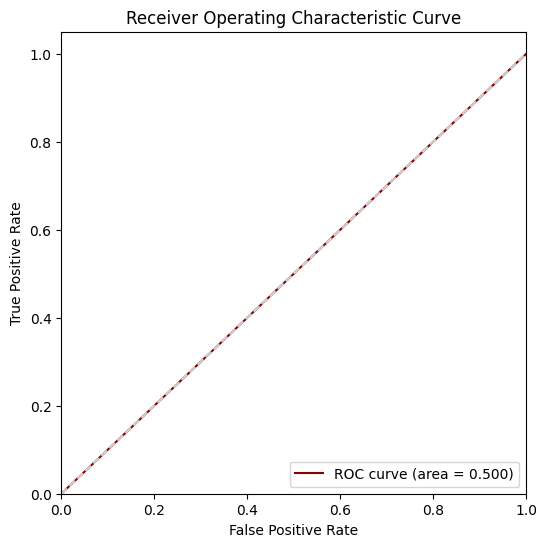

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(criterion='gini', max_depth = 10, n_estimators= 100)

rf1.fit(data_p.drop("is_fraud", axis = 1), data_p["is_fraud"])
eval_result(rf1, validation_p.drop("is_fraud", axis = 1), validation_p["is_fraud"],validation= True)

#### XGBOOST


               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     30958
       Fraud       0.77      0.73      0.75       163

    accuracy                           1.00     31121
   macro avg       0.89      0.86      0.87     31121
weighted avg       1.00      1.00      1.00     31121
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,30923,35
Fraud,44,119


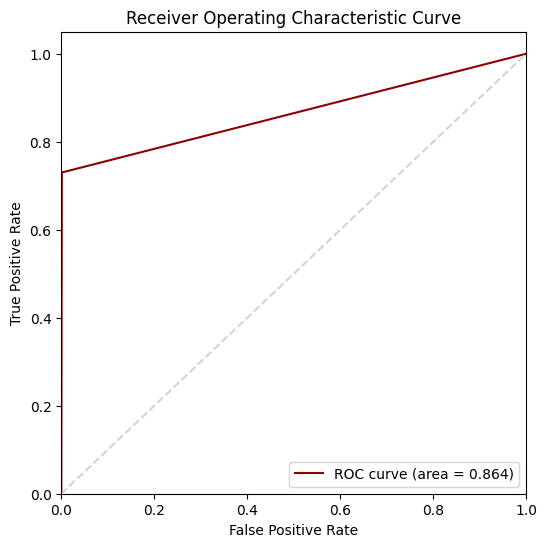

In [ ]:
xgbr = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr.fit(data_p.drop("is_fraud", axis = 1), data_p["is_fraud"])
eval_result(xgbr, validation_p.drop("is_fraud", axis = 1), validation_p["is_fraud"],validation= True)

### AUGMENTED

#### RANDOM FOREST


               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     30958
       Fraud       0.65      0.66      0.66       163

    accuracy                           1.00     31121
   macro avg       0.83      0.83      0.83     31121
weighted avg       1.00      1.00      1.00     31121
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,30901,57
Fraud,55,108


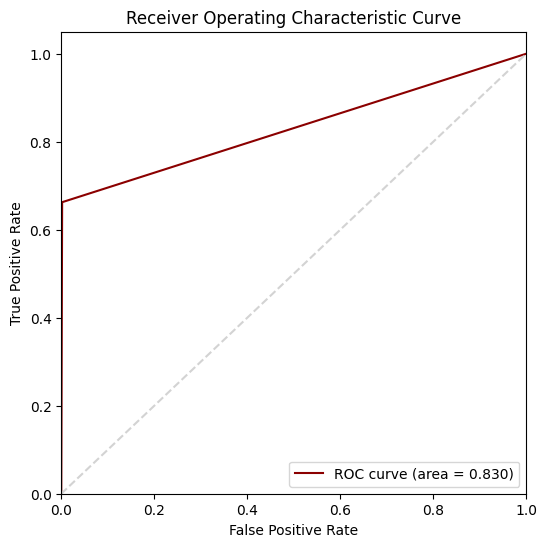

In [ ]:
clf2 = RandomForestClassifier(criterion='gini', max_depth = 10, n_estimators= 100)

clf2.fit(aug_df_p.drop("is_fraud", axis = 1), aug_df_p["is_fraud"])
eval_result(clf2, validation_p.drop("is_fraud", axis = 1), validation_p["is_fraud"],validation= True)

#### XGBOOST


               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     30958
       Fraud       0.64      0.79      0.71       163

    accuracy                           1.00     31121
   macro avg       0.82      0.89      0.85     31121
weighted avg       1.00      1.00      1.00     31121
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,30887,71
Fraud,35,128


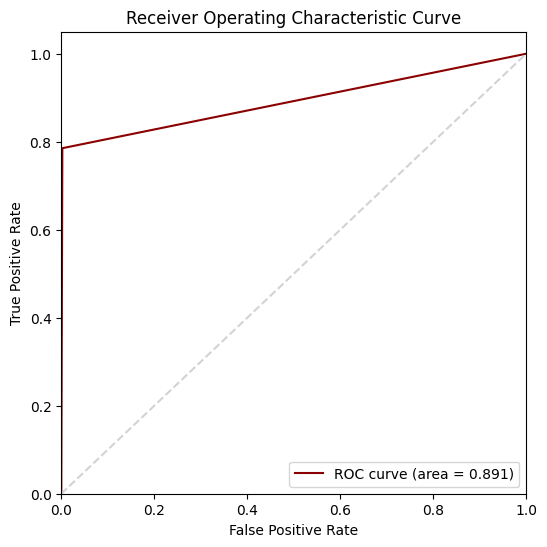

In [ ]:
xgbr2 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr2.fit(aug_df_p.drop("is_fraud", axis = 1), aug_df_p["is_fraud"])
eval_result(xgbr2, validation_p.drop("is_fraud", axis = 1), validation_p["is_fraud"],validation= True)

### GENERATED+AUGMENTED

#### RANDOM FOREST


               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     30958
       Fraud       0.59      0.61      0.60       163

    accuracy                           1.00     31121
   macro avg       0.79      0.81      0.80     31121
weighted avg       1.00      1.00      1.00     31121
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,30889,69
Fraud,63,100


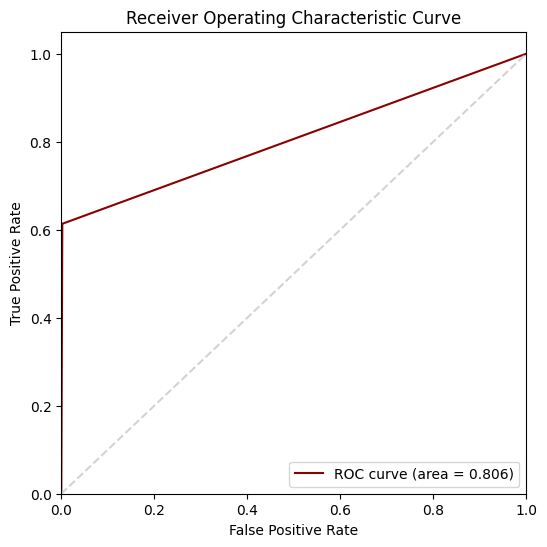

In [ ]:
clf3 = RandomForestClassifier(criterion='gini', max_depth = 10, n_estimators= 100)

clf3.fit(synth_p.drop("is_fraud", axis = 1), synth_p["is_fraud"])
eval_result(clf3, validation_p.drop("is_fraud", axis = 1), validation_p["is_fraud"],validation= True)

#### XGBOOST


               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     30958
       Fraud       0.71      0.58      0.64       163

    accuracy                           1.00     31121
   macro avg       0.85      0.79      0.82     31121
weighted avg       1.00      1.00      1.00     31121
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,30919,39
Fraud,69,94


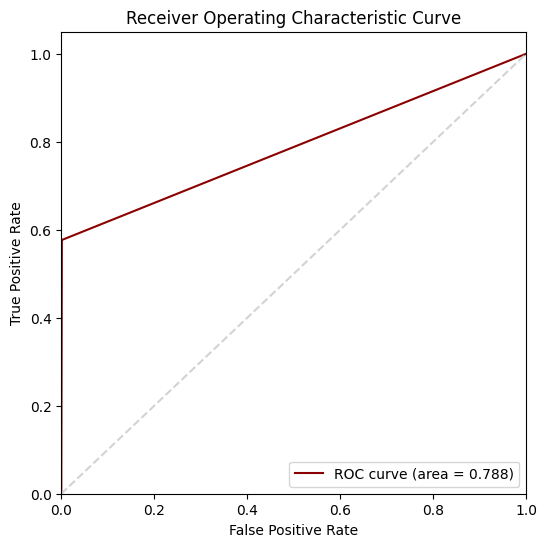

In [ ]:
xgbr3 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr3.fit(synth_p.drop("is_fraud", axis = 1), synth_p["is_fraud"])
eval_result(xgbr3, validation_p.drop("is_fraud", axis = 1), validation_p["is_fraud"],validation= True)

## SAVE THE MODEL

In [ ]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
synth_p['is_fraud'].value_counts()

0    9000
1    1000
Name: is_fraud, dtype: int64

### Without date processing

In [ ]:
df

,trans_date_trans_time,category,amt,gender,state,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud
0,2019-02-25 08:24:40,grocery_net,20.00,F,ND,47.1709,-100.7944,1190,1948-06-30,1330158280,46.398331,-99.813959,0
1,2019-04-12 19:50:15,home,284.88,F,WA,46.5901,-117.1692,761,1943-06-30,1334260215,45.687331,-117.488135,0
2,2020-05-31 21:50:53,shopping_net,5.07,F,FL,27.9551,-82.2966,79613,1978-11-30,1370037053,27.254081,-81.974799,0
3,2019-09-20 17:06:52,food_dining,45.38,F,GA,34.0770,-84.3033,165556,1997-12-27,1348160812,34.551957,-83.374265,0
4,2019-08-31 23:22:50,health_fitness,27.52,M,MI,43.6088,-83.9530,67858,1995-03-13,1346455370,43.032957,-83.521294,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,2020-03-16 15:40:37,food_dining,2.21,F,NY,44.2320,-74.4905,6120,1976-10-09,1363448437,45.161122,-74.432926,0
2589,2019-07-08 03:36:03,shopping_pos,7.68,F,NE,41.4193,-99.3844,73,1935-02-10,1341718563,40.650021,-99.794666,0
2590,2020-03-23 00:41:25,shopping_pos,4.47,F,TN,36.3846,-89.4649,5577,1964-12-30,1363999285,36.518271,-89.425881,0
2591,2020-03-24 22:21:43,health_fitness,45.88,M,PA,41.5177,-78.2536,4533,1969-11-01,1364163703,41.443764,-78.885192,0


In [ ]:
num_var = ['amt','lat','long','city_pop','unix_time','merch_lat', 'merch_long'
]

sensitive_cols = ['gender', 'state']

cat_var = ['category','gender', 'state'
,'trans_date_trans_time','dob'
]

taget = ['is_fraud']

df = df[cat_var+num_var+taget]

In [ ]:
df['is_fraud'].value_counts()

0    6452
1      31
Name: is_fraud, dtype: int64

In [ ]:
data, validation = train_test_split(df, test_size = 0.3, random_state = 42)

In [ ]:
fraud_df = data[data['is_fraud'] ==1].drop('is_fraud',axis=1)
no_fraud_df = data[data['is_fraud'] ==0].drop('is_fraud',axis=1)

In [ ]:
print(len(fraud_df))
print(len(no_fraud_df))

18
4520


In [ ]:
generator_no_fraud = Generator(num_epochs=2, n_samples=4500, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=no_fraud_df,
                          categorical_columns=cat_var,
                          sensitive_columns=sensitive_cols)

generator_fraud = Generator(num_epochs=2, n_samples=100, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=fraud_df,
                          categorical_columns=cat_var,
                          sensitive_columns=sensitive_cols)

generator_fraud_aug = Generator(num_epochs=2, n_samples=80, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=fraud_df,
                          categorical_columns=cat_var,
                          sensitive_columns=sensitive_cols)

Retrieving metadata, check with generator.metadata
Retrieving metadata, check with generator.metadata
Retrieving metadata, check with generator.metadata


In [ ]:
synth_no_fraud = generator_no_fraud.generate()
synth_fraud = generator_fraud.generate()
synth_fraud_aug = generator_fraud_aug.generate()

Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 37...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.000320
std       0.004788
min      -0.008428
25%      -0.002827
50%       0.000703
75%       0.004294
max       0.010843
dtype: float64
Sensitivity threshold: 0.007860511518229635 qt_max: 0.05


Map:   0%|          | 0/4520 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,5.473400
40,3.283800
60,2.688100
80,2.401700
100,2.221800
120,2.103900
140,2.027700
160,1.961600
180,1.935300
200,1.907000


  0%|          | 0/2235 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 2304 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.007860511518229635,                         val_sensitivity: -0.0224586129753915,                             val_sensitivities: [-0.023911663341193542, -0.021988935243968805, -0.02283783783783784, -0.023810085253038276, -0.024201886450208605, -0.02201795755487031, -0.022148557953927082, -0.022431525485216756, -0.021880101578088153, -0.022300925086159988, -0.02108924360602213, -0.021372211137311813, -0.02308452748050064, -0.021553600580446215, -0.02225013604208235]


  0%|          | 0/4500 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 4608 samples generated. Sampling efficiency is: 100.0000%
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 2...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.115000
std       0.185164
min      -0.025000
25%      -0.025000
50%      -0.025000
75%       0.175000
max       0.575000
dtype: float64
Sensitivity threshold: 0.475 qt_max: 0.05


Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


  0%|          | 0/6 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 128 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.475,                         val_sensitivity: 0.26833333333333326,                             val_sensitivities: [0.475, 0.17500000000000002, 0.375, -0.025, 0.575, -0.025, 0.775, 0.975, -0.025, 0.375, 0.17500000000000002, 0.275, -0.025, -0.025, -0.025]


  0%|          | 0/100 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 128 samples generated. Sampling efficiency is: 100.0000%
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 2...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.115000
std       0.185164
min      -0.025000
25%      -0.025000
50%      -0.025000
75%       0.175000
max       0.575000
dtype: float64
Sensitivity threshold: 0.475 qt_max: 0.05


Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


  0%|          | 0/6 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 128 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.475,                         val_sensitivity: 0.26833333333333326,                             val_sensitivities: [0.475, 0.17500000000000002, 0.375, -0.025, 0.575, -0.025, 0.775, 0.975, -0.025, 0.375, 0.17500000000000002, 0.275, -0.025, -0.025, -0.025]


  0%|          | 0/80 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 128 samples generated. Sampling efficiency is: 100.0000%


In [ ]:
similarity_checker_nofraud = SimilarityCheck(generator_no_fraud.data, synth_no_fraud, cat_var, generator_no_fraud.metadata)
similarity_checker_fraud = SimilarityCheck(generator_fraud.data, synth_fraud, cat_var, generator_fraud.metadata)
similarity_checker_fraud_aug = SimilarityCheck(generator_fraud_aug.data, synth_fraud_aug, cat_var, generator_fraud_aug.metadata)

similarity_checker_nofraud.comparison_columns()
similarity_checker_fraud.comparison_columns()
similarity_checker_fraud_aug.comparison_columns()

Creating report: 100%|██████████| 4/4 [00:13<00:00,  3.36s/it]



Overall Quality Score: 74.07%

Properties:
Column Shapes: 81.6%
Column Pair Trends: 66.54%
                   Column        Metric  Quality Score
0                     amt  KSComplement       0.957872
1                     lat  KSComplement       0.939270
2                    long  KSComplement       0.940670
3                city_pop  KSComplement       0.846962
4               unix_time  KSComplement       0.981181
5               merch_lat  KSComplement       0.945676
6              merch_long  KSComplement       0.946152
7                category  TVComplement       0.940161
8                  gender  TVComplement       0.988015
9                   state  TVComplement       0.816257
10  trans_date_trans_time  TVComplement       0.132080
11                    dob  TVComplement       0.357472


Creating report: 100%|██████████| 4/4 [00:00<00:00, 11.87it/s]



Overall Quality Score: 62.97%

Properties:
Column Shapes: 77.19%
Column Pair Trends: 48.74%
                   Column        Metric  Quality Score
0                     amt  KSComplement       0.780000
1                     lat  KSComplement       0.816667
2                    long  KSComplement       0.736667
3                city_pop  KSComplement       0.802222
4               unix_time  KSComplement       0.743333
5               merch_lat  KSComplement       0.795556
6              merch_long  KSComplement       0.716667
7                category  TVComplement       0.831111
8                  gender  TVComplement       0.691111
9                   state  TVComplement       0.774444
10  trans_date_trans_time  TVComplement       0.815556
11                    dob  TVComplement       0.760000


Creating report: 100%|██████████| 4/4 [00:00<00:00, 12.09it/s]



Overall Quality Score: 62.99%

Properties:
Column Shapes: 77.37%
Column Pair Trends: 48.61%
                   Column        Metric  Quality Score
0                     amt  KSComplement       0.787500
1                     lat  KSComplement       0.841667
2                    long  KSComplement       0.729167
3                city_pop  KSComplement       0.809722
4               unix_time  KSComplement       0.733333
5               merch_lat  KSComplement       0.793056
6              merch_long  KSComplement       0.716667
7                category  TVComplement       0.848611
8                  gender  TVComplement       0.686111
9                   state  TVComplement       0.756944
10  trans_date_trans_time  TVComplement       0.806944
11                    dob  TVComplement       0.775000
